# LSTM Weather Forecasting

This notebook trains an LSTM (Long Short-Term Memory) model for weather forecasting.

**Model Type**: Deep learning recurrent neural network
**Approach**: Sequence-to-sequence prediction
**Target Variables**: temperature, relative_humidity, wind_speed_10m
**Input Window**: 168 hours (7 days)
**Prediction Window**: 72 hours (3 days)
**Training**: GPU recommended (Colab T4: ~30-45 minutes, CPU: 2-6 hours)

**🚀 RECOMMENDED: Run on Google Colab with GPU enabled**

## 1. Setup & Installation

In [1]:
# Install required packages
import subprocess
import sys

packages = [
    'torch',
    'pandas',
    'numpy',
    'matplotlib',
    'scikit-learn',
    'joblib',
    'tqdm'
]

print("Installing packages...")
for package in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
print("✅ All packages installed!")

Installing packages...
✅ All packages installed!


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import json
import warnings
from tqdm import tqdm
import time
from pathlib import Path

warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n✅ Imports successful!")
print(f"🖥️  Device: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️  WARNING: No GPU detected! Training will be SLOW on CPU.")
    print("   Consider running on Google Colab with GPU enabled.")


✅ Imports successful!
🖥️  Device: cuda
🎮 GPU: Tesla T4
💾 Memory: 15.83 GB


## 2. Configuration

In [20]:
config = {
    # Data paths
    'data_path': '/content/Weather_Data_1980_2024(hourly).csv',  # Local path
    # If running on Colab, uncomment below and upload file:
    # 'data_path': '/content/Weather_Data_1980_2024(hourly).csv',
    'models_dir': '/content/models',

    # Input features (all 7 weather variables)
    'input_features': [
        'temperature',
        'relative_humidity',
        'dew_point',
        'wind_speed_10m (km/h)',
        'pressure_msl (hPa)',
        'cloud_cover (%)',
        'vapour_pressure_deficit (kPa)'
    ],

    # Target variables to predict
    'target_variables': [
        'temperature',
        'relative_humidity',
        'wind_speed_10m (km/h)'
    ],

    # Window sizes
    'input_window': 168,   # 7 days
    'output_window': 72,   # 3 days

    # Data split
    'train_split': 0.8,
    'val_split': 0.1,  # Remaining 0.1 for test

    # Model architecture
    'hidden_size': 128,
    'num_layers': 2,
    'dropout': 0.2,
    'bidirectional': False,

    # Training settings
    'batch_size': 64,
    'epochs': 20,
    'learning_rate': 0.001,
    'weight_decay': 0.0001,
    'gradient_clip': 1.0,
    'early_stopping_patience': 5,
}

# Calculate dimensions
config['input_dim'] = len(config['input_features'])
config['output_dim'] = len(config['target_variables'])

print("Configuration:")
print(json.dumps({k: v for k, v in config.items() if not k.endswith('_features')}, indent=2))
print(f"\nInput features ({config['input_dim']}): {config['input_features'][:3]}...")
print(f"Output variables ({config['output_dim']}): {config['target_variables']}")

Configuration:
{
  "data_path": "/content/Weather_Data_1980_2024(hourly).csv",
  "models_dir": "/content/models",
  "target_variables": [
    "temperature",
    "relative_humidity",
    "wind_speed_10m (km/h)"
  ],
  "input_window": 168,
  "output_window": 72,
  "train_split": 0.8,
  "val_split": 0.1,
  "hidden_size": 128,
  "num_layers": 2,
  "dropout": 0.2,
  "bidirectional": false,
  "batch_size": 64,
  "epochs": 20,
  "learning_rate": 0.001,
  "weight_decay": 0.0001,
  "gradient_clip": 1.0,
  "early_stopping_patience": 5,
  "input_dim": 7,
  "output_dim": 3
}

Input features (7): ['temperature', 'relative_humidity', 'dew_point']...
Output variables (3): ['temperature', 'relative_humidity', 'wind_speed_10m (km/h)']


## 3. Dataset Class

In [11]:
class WeatherLSTMDataset(Dataset):
    """Dataset for LSTM weather forecasting"""

    def __init__(self, data, config, target_indices):
        """
        Args:
            data: Normalized numpy array of all features
            config: Configuration dict
            target_indices: Indices of target variables in the feature array
        """
        self.data = data
        self.config = config
        self.target_indices = target_indices

    def __len__(self):
        return len(self.data) - self.config['input_window'] - self.config['output_window']

    def __getitem__(self, idx):
        # Input: all features for input_window
        x = self.data[idx:idx + self.config['input_window']]

        # Output: selected variables for output_window
        y_full = self.data[idx + self.config['input_window']:
                          idx + self.config['input_window'] + self.config['output_window']]
        y = y_full[:, self.target_indices]

        return (
            torch.tensor(x, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32)
        )

print("✅ Dataset class defined")

✅ Dataset class defined


## 4. Load and Prepare Data

In [12]:
print("Loading data...")
df = pd.read_csv(config['data_path'])

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

# Clean data
df_clean = df[config['input_features']].dropna().reset_index(drop=True)
print(f"\nClean dataset shape: {df_clean.shape}")
print(f"Removed {len(df) - len(df_clean)} rows with missing values")

Loading data...
Dataset shape: (389496, 17)

First few rows:
               time  temperature  relative_humidity  dew_point  \
0  1980-01-01T00:00         12.7                 83       10.0   
1  1980-01-01T01:00         12.9                 82        9.9   
2  1980-01-01T02:00         13.2                 82       10.2   
3  1980-01-01T03:00         15.9                 78       12.0   
4  1980-01-01T04:00         19.4                 67       13.1   

   precipitation (mm)  rain (mm)  snowfall (cm)  pressure_msl (hPa)  \
0                 0.0        0.0              0              1012.8   
1                 0.0        0.0              0              1012.2   
2                 0.0        0.0              0              1012.3   
3                 0.0        0.0              0              1013.5   
4                 0.0        0.0              0              1014.6   

   surface_pressure (hPa)  cloud_cover (%)  cloud_cover_low (%)  \
0                   945.1                1      

In [13]:
# Normalize data
print("\nNormalizing data...")
scaler = MinMaxScaler()

# Calculate split indices
total_len = len(df_clean)
train_idx = int(config['train_split'] * total_len)
val_idx = train_idx + int(config['val_split'] * total_len)

# Fit scaler on training data only
train_data_raw = df_clean.iloc[:train_idx].values
scaler.fit(train_data_raw)

# Transform all data
data_normalized = scaler.transform(df_clean.values)

print(f"✅ Data normalized using MinMaxScaler")
print(f"   Feature range: [0, 1]")
print(f"   Original ranges: {scaler.data_min_} to {scaler.data_max_}")

# Get target variable indices
target_indices = [config['input_features'].index(var) for var in config['target_variables']]
print(f"\nTarget variable indices: {target_indices}")

# Split data
train_data = data_normalized[:train_idx]
val_data = data_normalized[train_idx:val_idx]
test_data = data_normalized[val_idx:]

print(f"\nData splits:")
print(f"  Train: 0 to {train_idx} ({train_idx:,} samples)")
print(f"  Val: {train_idx} to {val_idx} ({val_idx - train_idx:,} samples)")
print(f"  Test: {val_idx} to {total_len} ({total_len - val_idx:,} samples)")


Normalizing data...
✅ Data normalized using MinMaxScaler
   Feature range: [0, 1]
   Original ranges: [  8.    6.  -11.8   0.  991.1   0.    0. ] to [  41.2   100.     24.8    40.3  1024.1   100.      7.21]

Target variable indices: [0, 1, 3]

Data splits:
  Train: 0 to 311596 (311,596 samples)
  Val: 311596 to 350545 (38,949 samples)
  Test: 350545 to 389496 (38,951 samples)


## 5. Create Data Loaders

In [14]:
# Create datasets
train_dataset = WeatherLSTMDataset(train_data, config, target_indices)
val_dataset = WeatherLSTMDataset(val_data, config, target_indices)
test_dataset = WeatherLSTMDataset(test_data, config, target_indices)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'],
                         shuffle=True, num_workers=0, pin_memory=True if torch.cuda.is_available() else False)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'],
                       shuffle=False, num_workers=0, pin_memory=True if torch.cuda.is_available() else False)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'],
                        shuffle=False, num_workers=0, pin_memory=True if torch.cuda.is_available() else False)

print(f"✅ Data loaders created:")
print(f"  Train batches: {len(train_loader):,}")
print(f"  Val batches: {len(val_loader):,}")
print(f"  Test batches: {len(test_loader):,}")
print(f"  Batch size: {config['batch_size']}")

✅ Data loaders created:
  Train batches: 4,865
  Val batches: 605
  Test batches: 605
  Batch size: 64


## 6. LSTM Model Architecture

In [15]:
class WeatherLSTM(nn.Module):
    """LSTM model for weather forecasting"""

    def __init__(self, config):
        super().__init__()
        self.config = config

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=config['input_dim'],
            hidden_size=config['hidden_size'],
            num_layers=config['num_layers'],
            dropout=config['dropout'] if config['num_layers'] > 1 else 0,
            batch_first=True,
            bidirectional=config['bidirectional']
        )

        # Calculate LSTM output size
        lstm_output_size = config['hidden_size'] * (2 if config['bidirectional'] else 1)

        # Output projection layers
        self.fc = nn.Sequential(
            nn.Linear(lstm_output_size, lstm_output_size * 2),
            nn.ReLU(),
            nn.Dropout(config['dropout']),
            nn.Linear(lstm_output_size * 2, lstm_output_size),
            nn.ReLU(),
            nn.Dropout(config['dropout']),
            nn.Linear(lstm_output_size, config['output_window'] * config['output_dim'])
        )

    def forward(self, x):
        # x: [batch, input_window, input_dim]

        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(x)

        # Use last hidden state
        if self.config['bidirectional']:
            # Concatenate forward and backward hidden states
            hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        else:
            hidden = hidden[-1]

        # Project to output
        output = self.fc(hidden)  # [batch, output_window * output_dim]

        # Reshape to [batch, output_window, output_dim]
        output = output.view(-1, self.config['output_window'], self.config['output_dim'])

        return output

# Create model
model = WeatherLSTM(config).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✅ Model created:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB")
print(f"\nModel architecture:")
print(model)


✅ Model created:
  Total parameters: 296,024
  Trainable parameters: 296,024
  Model size: ~1.13 MB

Model architecture:
WeatherLSTM(
  (lstm): LSTM(7, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=216, bias=True)
  )
)


## 7. Training Functions

In [16]:
def train_epoch(model, train_loader, optimizer, criterion, device, config):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    batch_count = 0

    pbar = tqdm(train_loader, desc='Training', leave=False)
    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config['gradient_clip'])

        optimizer.step()

        total_loss += loss.item()
        batch_count += 1
        pbar.set_postfix({'loss': f'{loss.item():.4f}',
                         'avg_loss': f'{total_loss/batch_count:.4f}'})

    return total_loss / batch_count


def validate(model, val_loader, criterion, device):
    """Validate model"""
    model.eval()
    total_loss = 0
    batch_count = 0

    with torch.no_grad():
        for x, y in tqdm(val_loader, desc='Validating', leave=False):
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            total_loss += loss.item()
            batch_count += 1

    return total_loss / batch_count

print("✅ Training functions defined")

✅ Training functions defined


## 8. Training Loop

In [18]:
# Training setup
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=config['learning_rate'],
                              weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                        factor=0.5, patience=3)
criterion = nn.MSELoss()

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'learning_rate': []
}

best_val_loss = float('inf')
epochs_without_improvement = 0

print("\n" + "="*80)
print("🚀 Starting Training")
print("="*80)
print(f"Device: {device}")
print(f"Epochs: {config['epochs']}")
print(f"Batch size: {config['batch_size']}")
print(f"Learning rate: {config['learning_rate']}")
print("="*80 + "\n")

training_start_time = time.time()

# Training loop
for epoch in range(1, config['epochs'] + 1):
    epoch_start_time = time.time()

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device, config)

    # Validate
    val_loss = validate(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['learning_rate'].append(current_lr)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0

        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'config': config,
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, '/content/models/lstm_best_model.pth')
        print(f"  💾 Saved best model (val_loss: {val_loss:.6f})")
    else:
        epochs_without_improvement += 1

    # Print progress
    epoch_time = time.time() - epoch_start_time
    print(f"\nEpoch {epoch}/{config['epochs']}:")
    print(f"  Train Loss: {train_loss:.6f}")
    print(f"  Val Loss: {val_loss:.6f}")
    print(f"  LR: {current_lr:.6f}")
    print(f"  Time: {epoch_time:.1f}s")
    print(f"  Best Val Loss: {best_val_loss:.6f}")
    print("-"*80)

    # Early stopping
    if epochs_without_improvement >= config['early_stopping_patience']:
        print(f"\n⚠️  Early stopping triggered after {epoch} epochs")
        print(f"   No improvement for {config['early_stopping_patience']} epochs")
        break

total_training_time = time.time() - training_start_time
print(f"\n✅ Training completed in {total_training_time/60:.1f} minutes")


🚀 Starting Training
Device: cuda
Epochs: 20
Batch size: 64
Learning rate: 0.001



  💾 Saved best model (val_loss: 0.006302)

Epoch 1/20:
  Train Loss: 0.007114
  Val Loss: 0.006302
  LR: 0.001000
  Time: 58.5s
  Best Val Loss: 0.006302
--------------------------------------------------------------------------------


  💾 Saved best model (val_loss: 0.006125)

Epoch 2/20:
  Train Loss: 0.006813
  Val Loss: 0.006125
  LR: 0.001000
  Time: 58.0s
  Best Val Loss: 0.006125
--------------------------------------------------------------------------------



Epoch 3/20:
  Train Loss: 0.006663
  Val Loss: 0.006254
  LR: 0.001000
  Time: 58.2s
  Best Val Loss: 0.006125
--------------------------------------------------------------------------------


  💾 Saved best model (val_loss: 0.006076)

Epoch 4/20:
  Train Loss: 0.006575
  Val Loss: 0.006076
  LR: 0.001000
  Time: 57.9s
  Best Val Loss: 0.006076
--------------------------------------------------------------------------------



Epoch 5/20:
  Train Loss: 0.006496
  Val Loss: 0.006221
  LR: 0.001000
  Time: 57.8s
  Best Val Loss: 0.006076
--------------------------------------------------------------------------------



Epoch 6/20:
  Train Loss: 0.006393
  Val Loss: 0.006077
  LR: 0.001000
  Time: 59.2s
  Best Val Loss: 0.006076
--------------------------------------------------------------------------------


  💾 Saved best model (val_loss: 0.006002)

Epoch 7/20:
  Train Loss: 0.006310
  Val Loss: 0.006002
  LR: 0.001000
  Time: 58.1s
  Best Val Loss: 0.006002
--------------------------------------------------------------------------------



Epoch 8/20:
  Train Loss: 0.006247
  Val Loss: 0.006094
  LR: 0.001000
  Time: 58.7s
  Best Val Loss: 0.006002
--------------------------------------------------------------------------------



Epoch 9/20:
  Train Loss: 0.006336
  Val Loss: 0.006203
  LR: 0.001000
  Time: 59.5s
  Best Val Loss: 0.006002
--------------------------------------------------------------------------------



Epoch 10/20:
  Train Loss: 0.006108
  Val Loss: 0.006223
  LR: 0.001000
  Time: 59.4s
  Best Val Loss: 0.006002
--------------------------------------------------------------------------------



Epoch 11/20:
  Train Loss: 0.006002
  Val Loss: 0.006195
  LR: 0.000500
  Time: 59.2s
  Best Val Loss: 0.006002
--------------------------------------------------------------------------------



Epoch 12/20:
  Train Loss: 0.005724
  Val Loss: 0.006268
  LR: 0.000500
  Time: 59.6s
  Best Val Loss: 0.006002
--------------------------------------------------------------------------------

⚠️  Early stopping triggered after 12 epochs
   No improvement for 5 epochs

✅ Training completed in 11.7 minutes


## 9. Plot Training History

📊 Saved training history to models/lstm_training_history.png


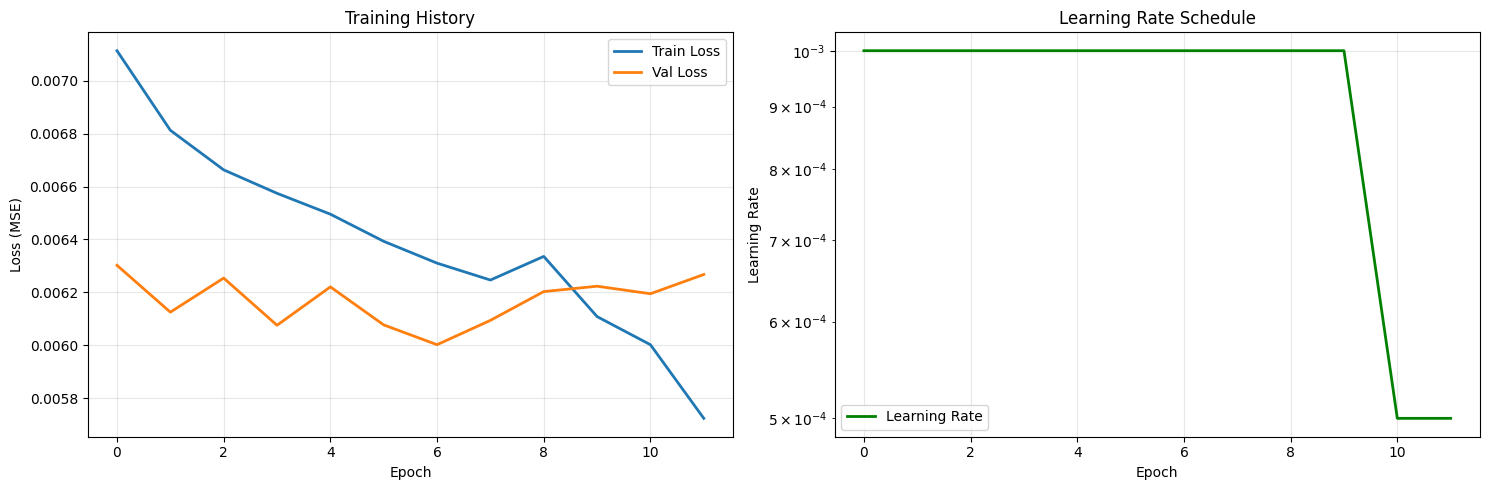

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Training History')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Learning rate plot
axes[1].plot(history['learning_rate'], label='Learning Rate', linewidth=2, color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/models/lstm_training_history.png', dpi=150, bbox_inches='tight')
print("📊 Saved training history to models/lstm_training_history.png")
plt.show()

## 10. Test Model Evaluation

In [22]:
print("\n" + "="*80)
print("📈 Evaluating on Test Set")
print("="*80)

# Load best model
checkpoint = torch.load('/content/models/lstm_best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']}")
print(f"Best validation loss: {checkpoint['val_loss']:.6f}")


📈 Evaluating on Test Set
Loaded best model from epoch 7
Best validation loss: 0.006002


In [23]:
# Calculate test metrics
test_loss = validate(model, test_loader, criterion, device)
print(f"\nTest Loss (MSE): {test_loss:.6f}")

# Calculate per-variable metrics
print("\n📊 Calculating per-variable metrics...")

all_predictions = []
all_actuals = []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc='Testing'):
        x, y = x.to(device), y.to(device)
        output = model(x)
        all_predictions.append(output.cpu().numpy())
        all_actuals.append(y.cpu().numpy())

# Concatenate all batches
predictions = np.concatenate(all_predictions, axis=0)  # [samples, 72, 3]
actuals = np.concatenate(all_actuals, axis=0)

print(f"Predictions shape: {predictions.shape}")
print(f"Actuals shape: {actuals.shape}")

# Calculate metrics per variable
test_metrics = {}
for i, var_name in enumerate(config['target_variables']):
    pred_var = predictions[:, :, i].flatten()
    actual_var = actuals[:, :, i].flatten()

    mse = mean_squared_error(actual_var, pred_var)
    mae = mean_absolute_error(actual_var, pred_var)
    rmse = np.sqrt(mse)

    test_metrics[var_name] = {
        'mse': float(mse),
        'mae': float(mae),
        'rmse': float(rmse)
    }

    print(f"\n{var_name}:")
    print(f"  MSE: {mse:.6f}")
    print(f"  MAE: {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")


Test Loss (MSE): 0.007194

📊 Calculating per-variable metrics...


Testing: 100%|██████████| 605/605 [00:03<00:00, 197.75it/s]


Predictions shape: (38711, 72, 3)
Actuals shape: (38711, 72, 3)

temperature:
  MSE: 0.002213
  MAE: 0.035300
  RMSE: 0.047046

relative_humidity:
  MSE: 0.010204
  MAE: 0.072063
  RMSE: 0.101013

wind_speed_10m (km/h):
  MSE: 0.009165
  MAE: 0.073307
  RMSE: 0.095734


## 11. Visualize Predictions

📊 Saved predictions plot to models/lstm_predictions.png


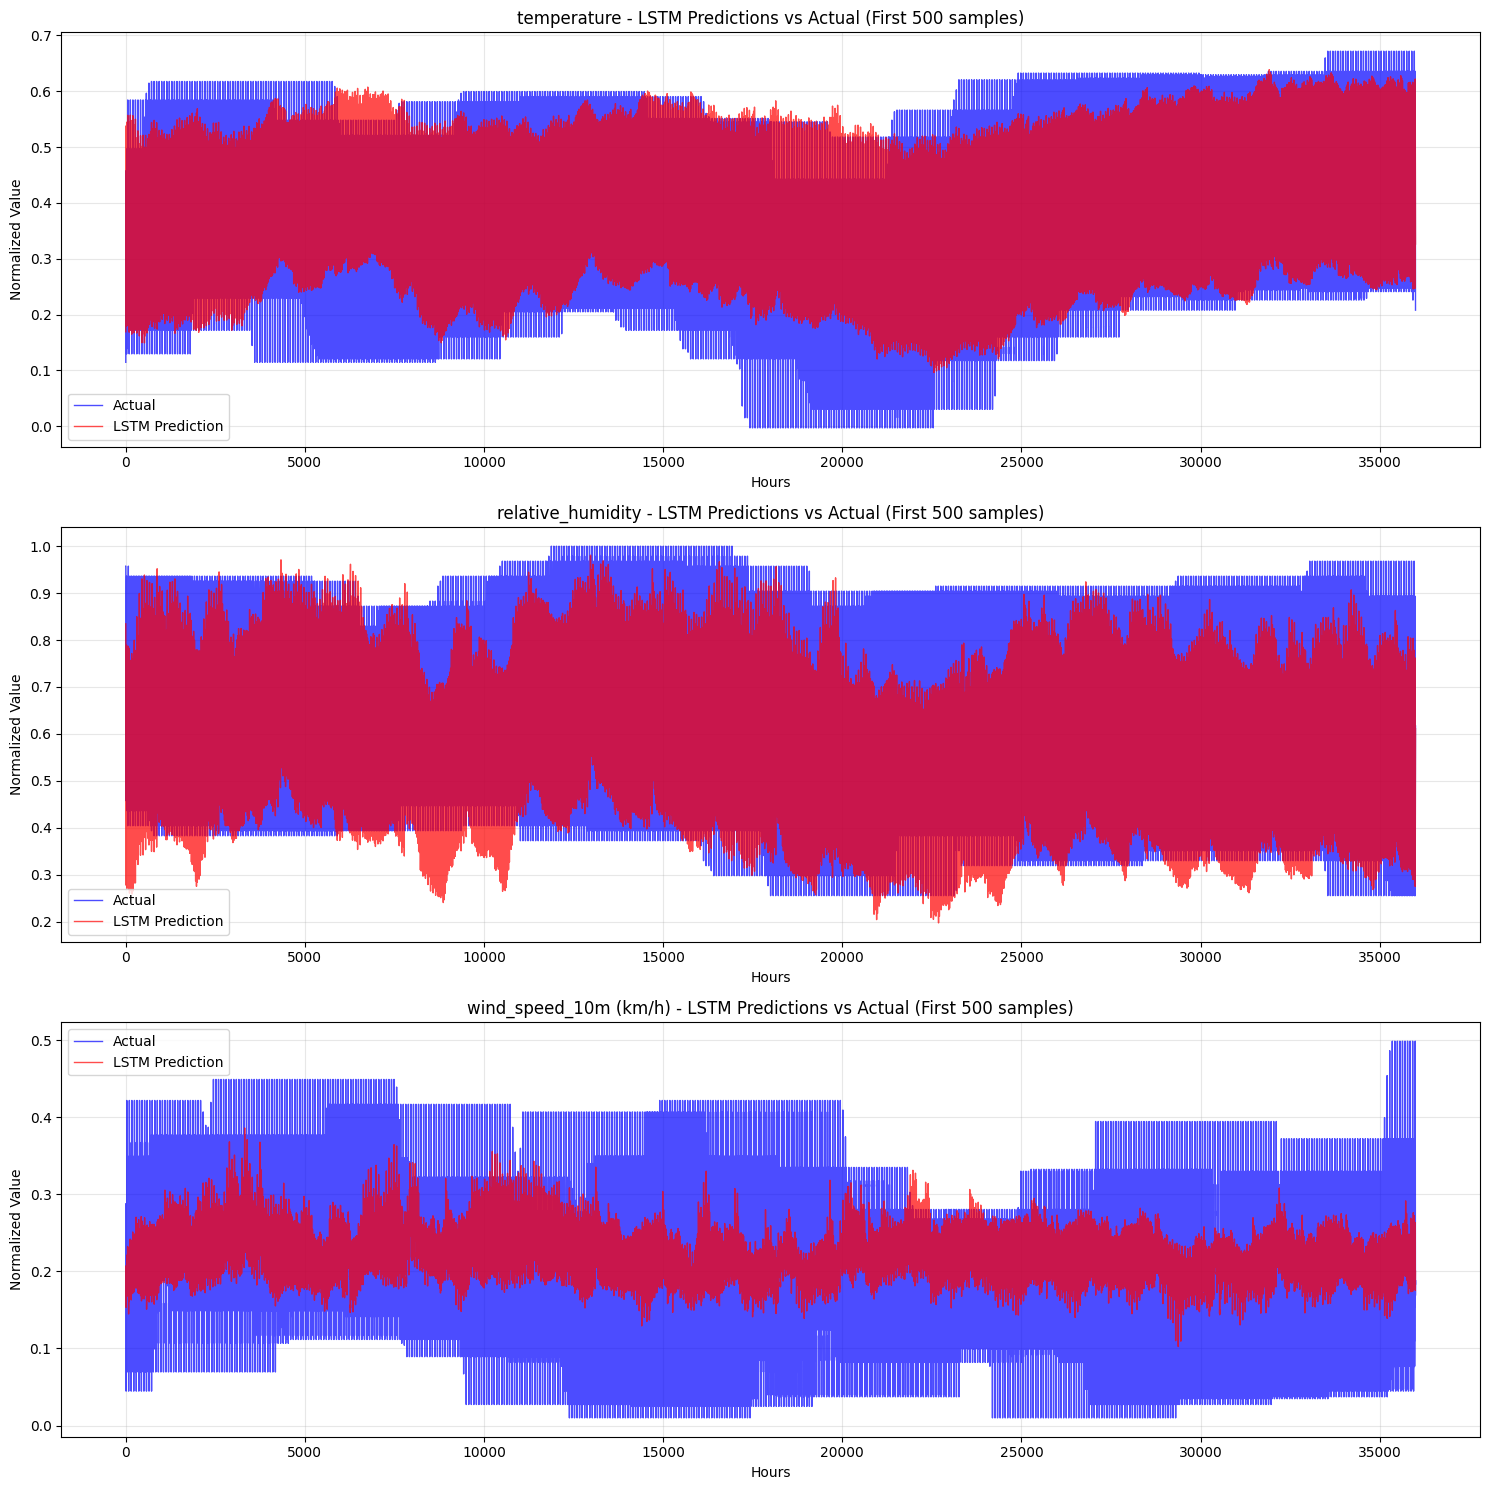

In [25]:
# Plot predictions vs actuals for each variable
fig, axes = plt.subplots(len(config['target_variables']), 1,
                         figsize=(15, 5*len(config['target_variables'])))

if len(config['target_variables']) == 1:
    axes = [axes]

for i, var_name in enumerate(config['target_variables']):
    ax = axes[i]

    # Get data for first 500 predictions
    plot_samples = min(500, predictions.shape[0])

    # Flatten time series
    pred_flat = predictions[:plot_samples, :, i].flatten()
    actual_flat = actuals[:plot_samples, :, i].flatten()
    time_steps = np.arange(len(pred_flat))

    ax.plot(time_steps, actual_flat, 'b-', label='Actual', alpha=0.7, linewidth=1)
    ax.plot(time_steps, pred_flat, 'r-', label='LSTM Prediction', alpha=0.7, linewidth=1)

    ax.set_xlabel('Hours')
    ax.set_ylabel('Normalized Value')
    ax.set_title(f'{var_name} - LSTM Predictions vs Actual (First {plot_samples} samples)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/models/lstm_predictions.png', dpi=150, bbox_inches='tight')
print("📊 Saved predictions plot to models/lstm_predictions.png")
plt.show()

📊 Saved 72-hour forecast plot to models/lstm_72hour_forecast.png


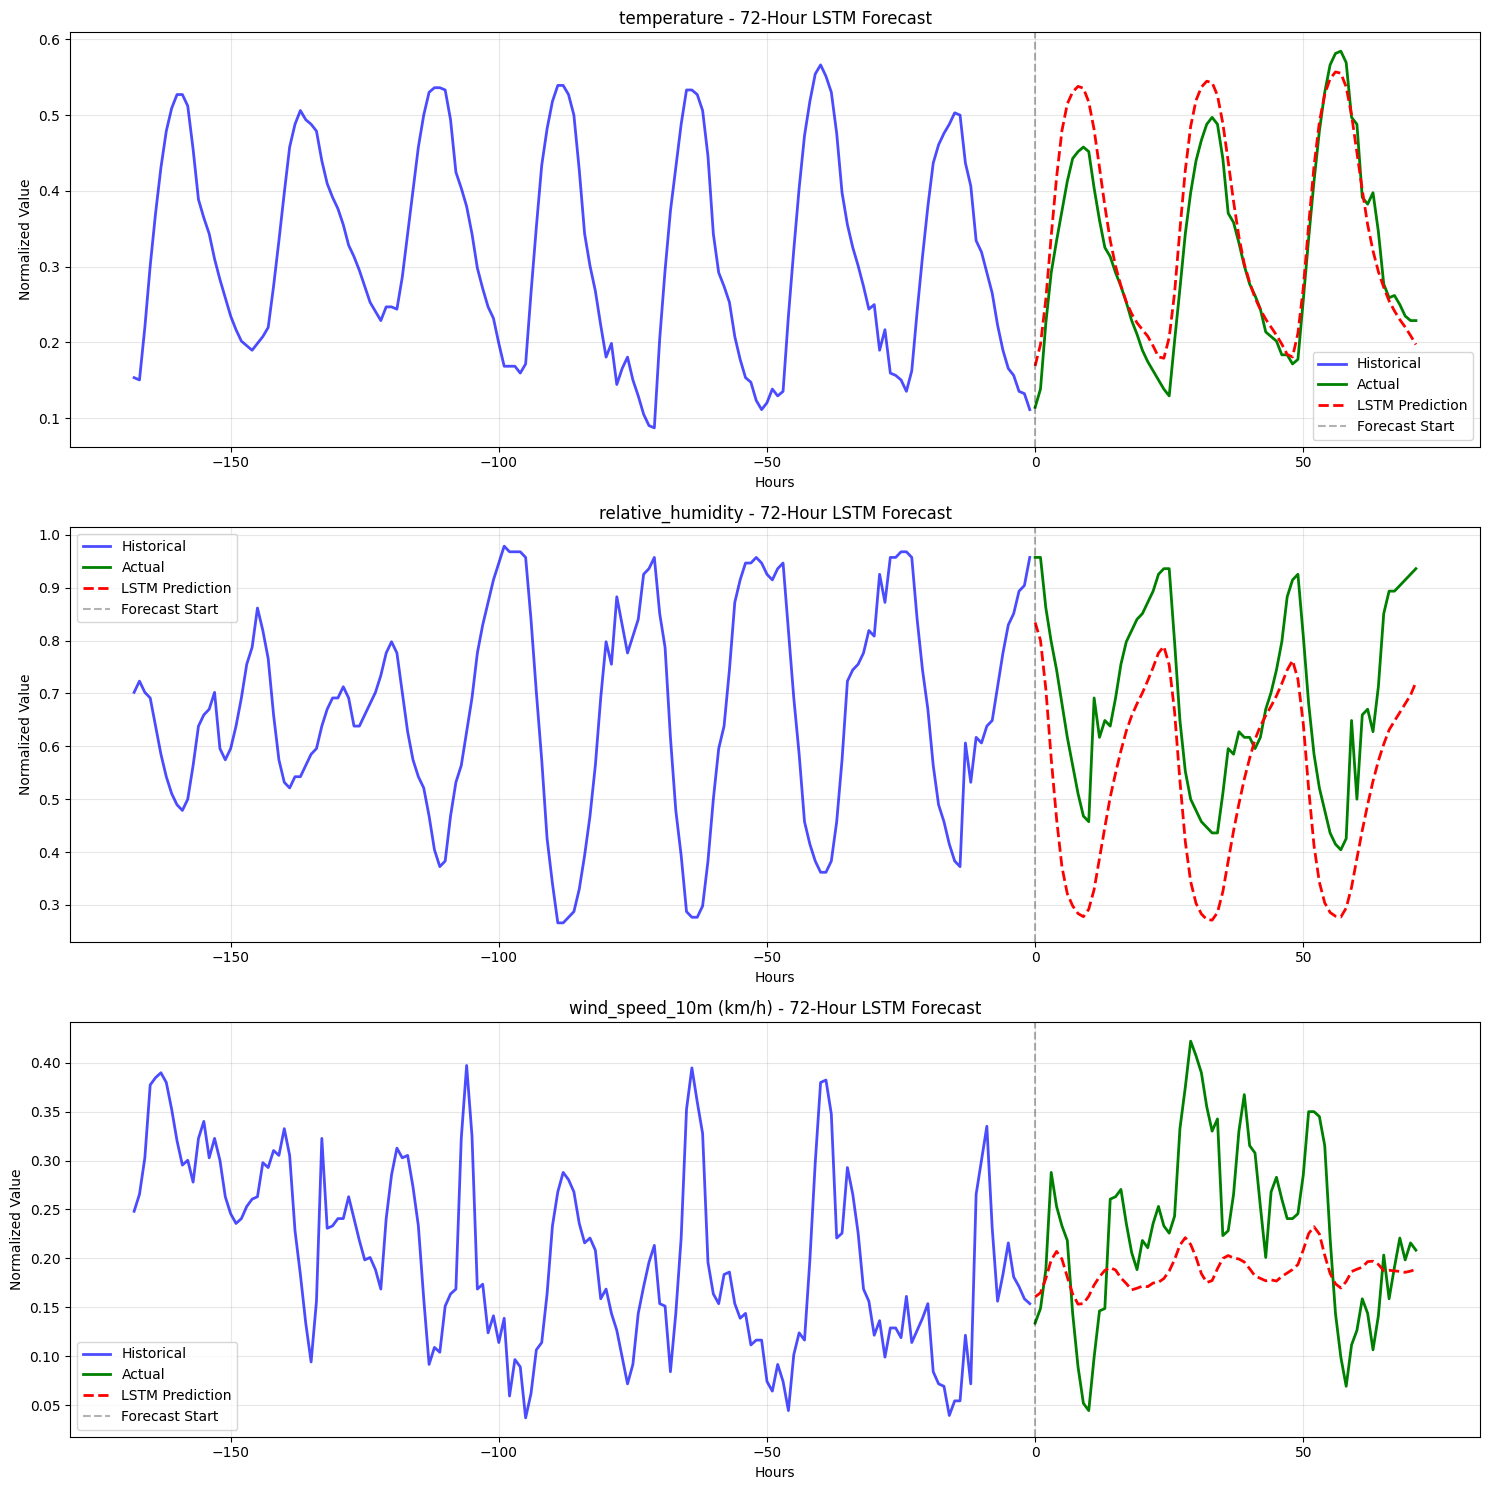

In [26]:
# Plot single 72-hour forecast with history
sample_idx = 0

# Get one test sample
test_iter = iter(test_loader)
x_sample, y_sample = next(test_iter)
x_sample, y_sample = x_sample.to(device), y_sample.to(device)

with torch.no_grad():
    y_pred_sample = model(x_sample)

# Convert to numpy
x_np = x_sample.cpu().numpy()[sample_idx]  # [168, 7]
y_actual_np = y_sample.cpu().numpy()[sample_idx]  # [72, 3]
y_pred_np = y_pred_sample.cpu().numpy()[sample_idx]  # [72, 3]

# Plot
fig, axes = plt.subplots(len(config['target_variables']), 1,
                         figsize=(15, 5*len(config['target_variables'])))

if len(config['target_variables']) == 1:
    axes = [axes]

for i, var_name in enumerate(config['target_variables']):
    ax = axes[i]

    # Get target variable index in input features
    var_idx = target_indices[i]

    # Historical data
    history = x_np[:, var_idx]  # 168 hours
    hist_time = np.arange(-config['input_window'], 0)

    # Forecast
    pred_time = np.arange(0, config['output_window'])

    ax.plot(hist_time, history, 'b-', label='Historical', alpha=0.7, linewidth=2)
    ax.plot(pred_time, y_actual_np[:, i], 'g-', label='Actual', linewidth=2)
    ax.plot(pred_time, y_pred_np[:, i], 'r--', label='LSTM Prediction', linewidth=2)

    ax.axvline(x=0, color='k', linestyle='--', alpha=0.3, label='Forecast Start')
    ax.set_xlabel('Hours')
    ax.set_ylabel('Normalized Value')
    ax.set_title(f'{var_name} - 72-Hour LSTM Forecast')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/models/lstm_72hour_forecast.png', dpi=150, bbox_inches='tight')
print("📊 Saved 72-hour forecast plot to models/lstm_72hour_forecast.png")
plt.show()

## 12. Analyze Forecast Horizon Performance

📊 Saved horizon analysis to models/lstm_horizon_analysis.png


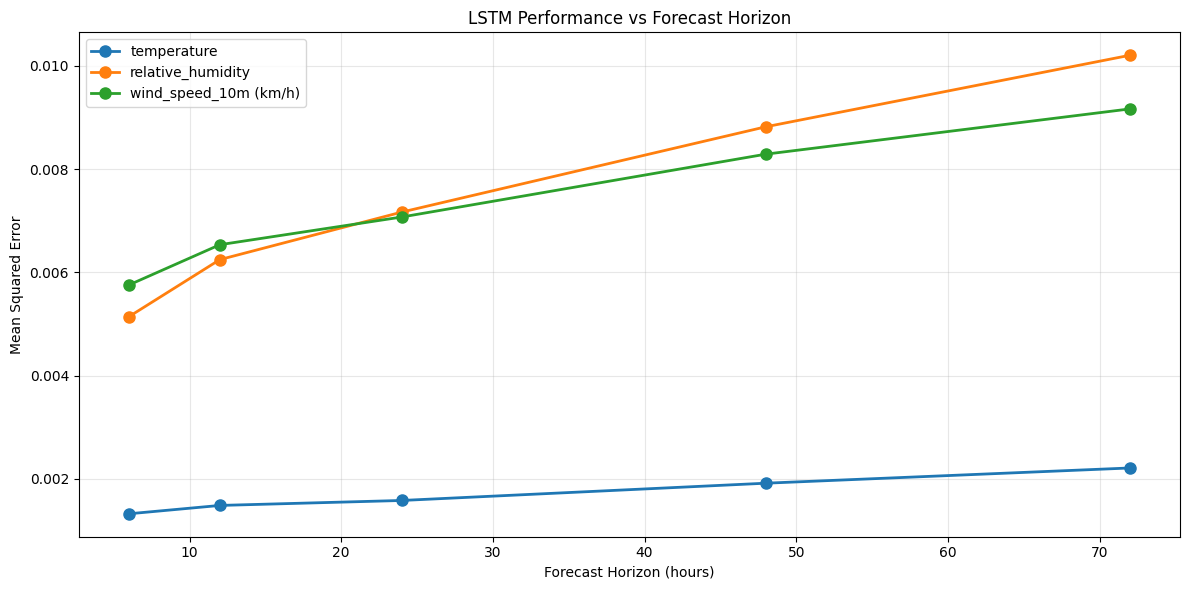

In [27]:
# Calculate MSE for different forecast horizons
horizons = [6, 12, 24, 48, 72]
horizon_metrics = {h: {} for h in horizons}

for horizon in horizons:
    for i, var_name in enumerate(config['target_variables']):
        pred_horizon = predictions[:, :horizon, i].flatten()
        actual_horizon = actuals[:, :horizon, i].flatten()

        mse = mean_squared_error(actual_horizon, pred_horizon)
        horizon_metrics[horizon][var_name] = mse

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

for i, var_name in enumerate(config['target_variables']):
    mse_values = [horizon_metrics[h][var_name] for h in horizons]
    ax.plot(horizons, mse_values, marker='o', label=var_name, linewidth=2, markersize=8)

ax.set_xlabel('Forecast Horizon (hours)')
ax.set_ylabel('Mean Squared Error')
ax.set_title('LSTM Performance vs Forecast Horizon')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/models/lstm_horizon_analysis.png', dpi=150, bbox_inches='tight')
print("📊 Saved horizon analysis to models/lstm_horizon_analysis.png")
plt.show()

## 13. Save Model and Artifacts

In [32]:
# Create models directory if it doesn't exist
models_dir = Path(config['models_dir'])
models_dir.mkdir(exist_ok=True)

print("\n💾 Saving LSTM model and artifacts...")

# Model already saved during training as lstm_best_model.pth

# Save model weights only (for easier loading)
torch.save(model.state_dict(), models_dir / 'lstm_model_weights.pth')
print(f"  ✓ Saved lstm_model_weights.pth")

# Save scaler
scaler_path = models_dir / 'lstm_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"  ✓ Saved lstm_scaler.pkl")

# Save results
results = {
    'config': config,
    'training_time': total_training_time,
    'best_epoch': int(checkpoint['epoch']),
    'best_val_loss': float(checkpoint['val_loss']),
    'test_loss': float(test_loss),
    'test_metrics': test_metrics,
    'horizon_metrics': {
        str(h): {var: float(mse) for var, mse in metrics.items()}
        for h, metrics in horizon_metrics.items()
    }
}

results_path = models_dir / 'lstm_results.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)
print(f"  ✓ Saved lstm_results.json")

# Save configuration
config_path = models_dir / 'lstm_config.json'
with open(config_path, 'w') as f:
    json.dump(config, f, indent=2)
print(f"  ✓ Saved lstm_config.json")

print("\n✅ All LSTM artifacts saved successfully!")
print(f"📁 Location: {models_dir.absolute()}")


💾 Saving LSTM model and artifacts...
  ✓ Saved lstm_model_weights.pth
  ✓ Saved lstm_scaler.pkl
  ✓ Saved lstm_results.json
  ✓ Saved lstm_config.json

✅ All LSTM artifacts saved successfully!
📁 Location: /content/models


## 14. Summary

In [33]:
print("\n" + "="*80)
print("🎉 LSTM Training Complete!")
print("="*80)

print(f"\n🖥️  Training Device: {device}")
print(f"⏱️  Total Training Time: {total_training_time/60:.1f} minutes")
print(f"📊 Best Epoch: {checkpoint['epoch']}")
print(f"📉 Best Val Loss: {checkpoint['val_loss']:.6f}")
print(f"📈 Test Loss: {test_loss:.6f}")

print(f"\n📊 Test Performance by Variable:")
for var in config['target_variables']:
    metrics = test_metrics[var]
    print(f"\n{var}:")
    print(f"  MSE: {metrics['mse']:.6f}")
    print(f"  MAE: {metrics['mae']:.6f}")
    print(f"  RMSE: {metrics['rmse']:.6f}")

print("\n📁 Saved Files:")
print(f"  - Best model: {models_dir}/lstm_best_model.pth")
print(f"  - Model weights: {models_dir}/lstm_model_weights.pth")
print(f"  - Scaler: {models_dir}/lstm_scaler.pkl")
print(f"  - Results: {models_dir}/lstm_results.json")
print(f"  - Configuration: {models_dir}/lstm_config.json")
print(f"  - Plots: {models_dir}/lstm_*.png")

print("\n🔜 Next Steps:")
if device.type == 'cuda':
    print("  ✅ Training completed successfully on GPU!")
    print("  1. Download the model files from models/ directory")
    print("  2. Place them in your local models/ directory")
    print("  3. Run model_comparison.py to compare all models")
else:
    print("  ⚠️  Training completed on CPU (may have taken longer)")
    print("  Consider re-training on Colab GPU for faster training")
    print("  Next: Run model_comparison.py to compare all models")

print("\n" + "="*80)


🎉 LSTM Training Complete!

🖥️  Training Device: cuda
⏱️  Total Training Time: 11.7 minutes
📊 Best Epoch: 7
📉 Best Val Loss: 0.006002
📈 Test Loss: 0.007194

📊 Test Performance by Variable:

temperature:
  MSE: 0.002213
  MAE: 0.035300
  RMSE: 0.047046

relative_humidity:
  MSE: 0.010204
  MAE: 0.072063
  RMSE: 0.101013

wind_speed_10m (km/h):
  MSE: 0.009165
  MAE: 0.073307
  RMSE: 0.095734

📁 Saved Files:
  - Best model: /content/models/lstm_best_model.pth
  - Model weights: /content/models/lstm_model_weights.pth
  - Scaler: /content/models/lstm_scaler.pkl
  - Results: /content/models/lstm_results.json
  - Configuration: /content/models/lstm_config.json
  - Plots: /content/models/lstm_*.png

🔜 Next Steps:
  ✅ Training completed successfully on GPU!
  1. Download the model files from models/ directory
  2. Place them in your local models/ directory
  3. Run model_comparison.py to compare all models

